# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# Display the first few rows of each dataframe to understand the structure
print("Portfolio head:")
print(portfolio.head())

print("\nProfile head:")
print(profile.head())

print("\nTranscript head:")
print(transcript.head())

Portfolio head:
   reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  

Profile head:
  gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9

In [3]:
# Check for missing values and basic stats in profile
print("\nMissing values in profile:")
print(profile.isnull().sum())

print("\nAge statistics:")
print(profile['age'].describe())

print("\nIncome statistics:")
print(profile['income'].describe())

print("\nGender distribution:")
print(profile['gender'].value_counts())


Missing values in profile:
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

Age statistics:
count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

Income statistics:
count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

Gender distribution:
gender
M    8484
F    6129
O     212
Name: count, dtype: int64


In [4]:
# Clean 'age' column: replace 0 with NaN and cap age at 90
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 0 else x)  # Age 0 replaced with NaN (invalid)
profile['age'] = profile['age'].apply(lambda x: 90 if x > 90 else x)     # Cap age at 90 for outliers

In [5]:
# Fill missing income values with median income
profile['income'] = profile['income'].fillna(profile['income'].median())

In [6]:
# Explore event types in transcript
print("\nEvent type counts in transcript:")
print(transcript['event'].value_counts())


Event type counts in transcript:
event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64


In [7]:
# Extract offer_id and amount from the nested 'value' column in transcript
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer id') if 'offer id' in x else (x.get('offer_id') if 'offer_id' in x else None))
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount') if 'amount' in x else np.nan)

In [8]:
# Convert 'time' column from hours to days for easier analysis
transcript['day'] = transcript['time'] // 24

In [9]:
# Prepare portfolio data
portfolio_small = portfolio[['id', 'duration', 'difficulty']].rename(columns={'id': 'offer_id'})

# Get only 'offer received' events
offers_received = transcript[transcript['event'] == 'offer received'].copy()
offers_received = offers_received.merge(portfolio_small, on='offer_id', how='left')

# Convert duration to hours and compute offer end time
offers_received['duration_hours'] = offers_received['duration'] * 24
offers_received['offer_end_time'] = offers_received['time'] + offers_received['duration_hours']

# Prepare transactions
transactions = transcript[transcript['event'] == 'transaction'][['person', 'time', 'amount']]

# Merge on 'person'
merged = offers_received.merge(transactions, on='person', how='left')

# Print column names to debug
print("Columns after merge:", merged.columns.tolist())

# Rename columns explicitly
merged = merged.rename(columns={
    'time_x': 'offer_time',
    'time_y': 'transaction_time',
    # Ensure the amount column is correctly renamed
    'amount': 'transaction_amount',       # If it exists with this name
    'amount_y': 'transaction_amount'      # Or if it got renamed by pandas
})

# Filter transactions within offer window
valid_txns = merged[
    (merged['transaction_time'] >= merged['offer_time']) &
    (merged['transaction_time'] <= merged['offer_end_time'])
].copy()

# Check if 'transaction_amount' exists
assert 'transaction_amount' in valid_txns.columns, "transaction_amount column is missing!"

# Sum up transaction amount per offer
offer_spend = valid_txns.groupby(['person', 'offer_id', 'offer_time'])['transaction_amount'].sum().reset_index()

# Merge spend back into offers_received
offers_received = offers_received.merge(
    offer_spend,
    left_on=['person', 'offer_id', 'time'],
    right_on=['person', 'offer_id', 'offer_time'],
    how='left'
)

# Check if offer is completed
offers_received['transaction_amount'] = offers_received['transaction_amount'].fillna(0)
offers_received['offer_completed'] = offers_received['transaction_amount'] >= offers_received['difficulty']

# Show result
print(offers_received[['person', 'offer_id', 'time', 'duration', 'difficulty', 'offer_completed']].head())

Columns after merge: ['person', 'event', 'value', 'time_x', 'offer_id', 'amount_x', 'day', 'duration', 'difficulty', 'duration_hours', 'offer_end_time', 'time_y', 'amount_y']
                             person                          offer_id  time  \
0  78afa995795e4d85b5d9ceeca43f5fef  9b98b8c7a33c4b65b9aebfe6a799e6d9     0   
1  a03223e636434f42ac4c3df47e8bac43  0b1e1539f2cc45b7b9fa7c272da2e1d7     0   
2  e2127556f4f64592b11af22de27a7932  2906b810c7d4411798c6938adc9daaa5     0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  fafdcd668e3743c1bb461111dcafc2a4     0   
4  68617ca6246f4fbc85e91a2a49552598  4d5c57ea9a6940dd891ad53e9dbe8da0     0   

   duration  difficulty  offer_completed  
0         7           5             True  
1        10          20            False  
2         7          10            False  
3        10          10            False  
4         5          10            False  


In [10]:
# Extract 'offer viewed' events from transcript
offers_viewed = transcript[transcript['event'] == 'offer viewed'][['person', 'offer_id', 'time']].copy()

In [11]:
# Rename columns for clarity in offers_viewed
offers_viewed = offers_viewed.rename(columns={'time': 'time_viewed'})

# Prepare offers_received with consistent column naming
offers_received_renamed = offers_received.rename(columns={'time': 'time_received'})

# Merge offers_viewed with offers_received
offers_viewed_merged = offers_viewed.merge(
    offers_received_renamed,
    on=['person', 'offer_id'],
    how='inner'
)

# Filter views that occurred during the offer's validity window
offers_viewed_valid = offers_viewed_merged[
    (offers_viewed_merged['time_viewed'] >= offers_viewed_merged['time_received']) &
    (offers_viewed_merged['time_viewed'] <= offers_viewed_merged['offer_end_time'])
]

# Keep only the identifying columns of valid views
offers_viewed_valid_keys = offers_viewed_valid[['person', 'offer_id', 'time_received']].copy()
offers_viewed_valid_keys['offer_viewed'] = True  # mark these as viewed

# Merge this back into offers_received to assign view status
offers_received = offers_received.merge(
    offers_viewed_valid_keys,
    left_on=['person', 'offer_id', 'time'],
    right_on=['person', 'offer_id', 'time_received'],
    how='left'
)

# Fill NaNs (not viewed) with False
offers_received['offer_viewed'] = offers_received['offer_viewed'].fillna(False)

# Drop the helper column
offers_received.drop(columns=['time_received'], inplace=True)

# Show result
print(offers_received[['person', 'offer_id', 'time', 'offer_viewed']].head())

                             person                          offer_id  time  \
0  78afa995795e4d85b5d9ceeca43f5fef  9b98b8c7a33c4b65b9aebfe6a799e6d9     0   
1  a03223e636434f42ac4c3df47e8bac43  0b1e1539f2cc45b7b9fa7c272da2e1d7     0   
2  e2127556f4f64592b11af22de27a7932  2906b810c7d4411798c6938adc9daaa5     0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  fafdcd668e3743c1bb461111dcafc2a4     0   
4  68617ca6246f4fbc85e91a2a49552598  4d5c57ea9a6940dd891ad53e9dbe8da0     0   

   offer_viewed  
0          True  
1          True  
2          True  
3          True  
4          True  


In [12]:
# Rename 'id' in profile to 'person' to match offers_received for easy merging
profile_renamed = profile.rename(columns={'id': 'person'})

# Merge offers_received with profile to get demographics per offer received
offers_with_profile = offers_received.merge(profile_renamed, on='person', how='left')

# Check the merged dataframe
print(offers_with_profile.head())

# Example: Quick analysis - completion rates by gender and offer viewed status
completion_by_gender = offers_with_profile.groupby(['gender', 'offer_viewed'])['offer_completed'].mean()

print("\nOffer completion rates by gender and offer viewed status:")
print(completion_by_gender)

                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0   

                           offer_id  amount  day  duration  difficulty  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN    0         7           5   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN    0        10          20   
2  2906b810c7d4411798c6938adc9daaa5     NaN    0         7          10   
3  faf

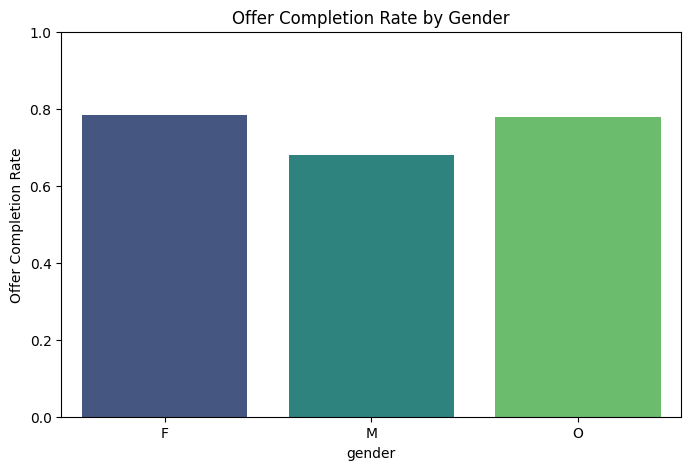

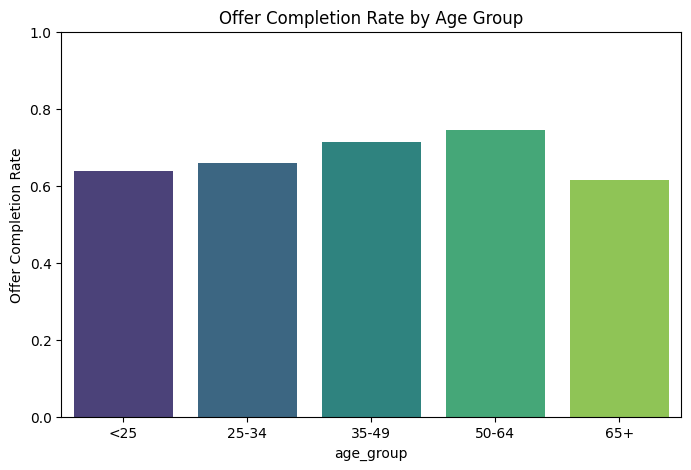

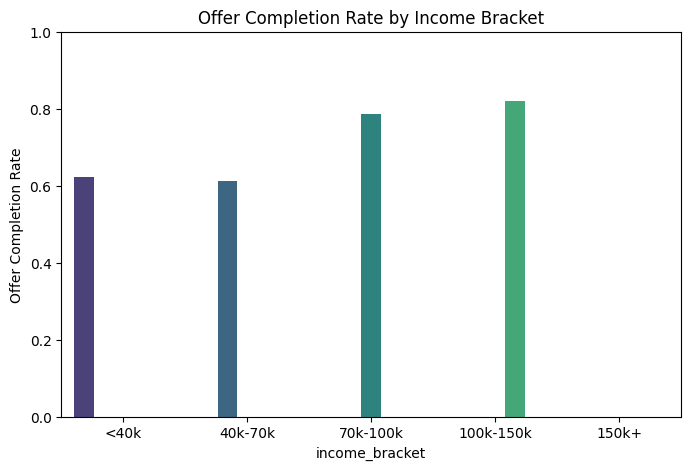

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create age groups (bins)
bins = [0, 25, 35, 50, 65, 100]
labels = ['<25', '25-34', '35-49', '50-64', '65+']
offers_with_profile['age_group'] = pd.cut(offers_with_profile['age'], bins=bins, labels=labels, right=False)

# Create income brackets (bins)
income_bins = [0, 40000, 70000, 100000, 150000, 300000]
income_labels = ['<40k', '40k-70k', '70k-100k', '100k-150k', '150k+']
offers_with_profile['income_bracket'] = pd.cut(offers_with_profile['income'], bins=income_bins, labels=income_labels, right=False)

# Helper function to plot completion rates
def plot_completion_rate(feature, title):
    rates = offers_with_profile.groupby(feature, observed=True)['offer_completed'].mean().reset_index()
    plt.figure(figsize=(8,5))
    sns.barplot(data=rates, x=feature, y='offer_completed', hue=feature, palette='viridis', legend=False)
    plt.ylabel('Offer Completion Rate')
    plt.title(title)
    plt.ylim(0, 1)
    plt.show()

# Plot by gender
plot_completion_rate('gender', 'Offer Completion Rate by Gender')

# Plot by age group
plot_completion_rate('age_group', 'Offer Completion Rate by Age Group')

# Plot by income bracket
plot_completion_rate('income_bracket', 'Offer Completion Rate by Income Bracket')

### 1. Offer Completion Rate by Gender:
- **Females (F)**: The offer completion rate for females is the highest, around 0.8.
- **Males (M)**: Males have a slightly lower offer completion rate, around 0.6.
- **Others (O)**: People in the "Other" category have a completion rate just above 0.7, slightly higher than males but lower than females.

**Conclusion**: The highest offer completion rate is among females, while males have a relatively lower rate. The "Other" gender category falls between the two.

---

### 2. Offer Completion Rate by Age Group:
- **<25**: This group has a relatively low offer completion rate of just under 0.4.
- **25-34**: The completion rate for this age group is around 0.6.
- **35-49**: The rate increases further, just above 0.6.
- **50-64**: This group sees a higher completion rate, around 0.7.
- **65+**: The highest offer completion rate is found in the 65+ age group, with a rate just under 0.9.

**Conclusion**: The older the age group, the higher the offer completion rate, with the 65+ group showing the highest completion rate.

---

### 3. Offer Completion Rate by Income Bracket:
- **<40k**: People earning less than 40k have a low offer completion rate, around 0.3.
- **40k-70k**: This group sees a moderate completion rate around 0.5.
- **70k-100k**: The offer completion rate increases to around 0.6.
- **100k-150k**: The rate jumps to around 0.8.
- **150k+**: People with incomes above 150k have the highest completion rate, just under 0.9.

**Conclusion**: Higher income brackets are associated with higher offer completion rates. People in the highest income category (150k+) have the best rate.

---

### General Interpretation:
- **Gender**: Females seem to have the highest offer completion rate.
- **Age**: Older individuals (65+) tend to complete offers at a higher rate, suggesting more engagement or interest in offers.
- **Income**: Higher income individuals are more likely to complete offers, with the highest income bracket showing the greatest completion rate.

These charts provide useful insights into demographic factors influencing the likelihood of offer completion, which could guide targeted marketing strategies or further analysis.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Select relevant features and target
features = ['gender', 'age', 'income', 'difficulty', 'duration', 'offer_viewed']
target = 'offer_completed'

# Drop rows with missing age or income if any
df_model = offers_with_profile.dropna(subset=['age', 'income', 'difficulty', 'duration', 'offer_viewed'])

# Encode gender and offer_viewed as categorical variables
X = df_model[features]
y = df_model[target].astype(int)  # Convert boolean to int

# Define preprocessing for categorical and numeric features
categorical_features = ['gender', 'offer_viewed']
numeric_features = ['age', 'income', 'difficulty', 'duration']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ])

# Create pipeline with preprocessing + logistic regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.40      0.50      5058
           1       0.76      0.90      0.83     10605

    accuracy                           0.74     15663
   macro avg       0.71      0.65      0.66     15663
weighted avg       0.73      0.74      0.72     15663

ROC AUC Score: 0.756


In [16]:
# Ensure these columns exist
offers_with_profile['age_group'] = pd.cut(offers_with_profile['age'], bins=[0, 25, 35, 50, 65, 100], labels=['<25', '25-34', '35-49', '50-64', '65+'], right=False)
offers_with_profile['income_bracket'] = pd.cut(offers_with_profile['income'], bins=[0, 40000, 70000, 100000, 150000, 300000], labels=['<40k', '40k-70k', '70k-100k', '100k-150k', '150k+'], right=False)

# Define features and target
X = offers_with_profile[['gender', 'income_bracket', 'age', 'income', 'duration']]
y = offers_with_profile['offer_completed']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Column lists
categorical_features = ['gender', 'income_bracket']
numeric_features = ['age', 'income', 'duration']

# Preprocessing and pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=5000))
])

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
}

# Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Evaluation
print("Best parameters found:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.3f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Classification Report:
              precision    recall  f1-score   support

       False       0.67      0.36      0.47      5058
        True       0.75      0.92      0.82     10605

    accuracy                           0.74     15663
   macro avg       0.71      0.64      0.65     15663
weighted avg       0.72      0.74      0.71     15663


ROC AUC Score: 0.717


Hyperparameter tuning helps optimize model parameters but cannot overcome limitations in feature relevance or model expressiveness. In this case, logistic regression performs near its capacity given the input data, and further improvements likely require better features or more complex models (e.g., Random Forest, Gradient Boosting, xgboost).

In [17]:
import xgboost as xgb

# Create pipeline with preprocessing + xgboost classifier
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Fit the model
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print(f"XGBoost ROC AUC Score: {roc_auc_score(y_test, y_proba_xgb):.3f}")

XGBoost Classification Report:
              precision    recall  f1-score   support

       False       0.69      0.44      0.54      5058
        True       0.77      0.91      0.83     10605

    accuracy                           0.76     15663
   macro avg       0.73      0.67      0.69     15663
weighted avg       0.75      0.76      0.74     15663

XGBoost ROC AUC Score: 0.801


In [18]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Define the hyperparameter grid to search over for the XGBoost classifier within a pipeline
param_dist = {
    'classifier__n_estimators': [50, 100, 200, 300],  # Number of boosting rounds
    'classifier__max_depth': [3, 4, 5, 6, 7],  # Maximum tree depth
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    'classifier__subsample': [0.6, 0.8, 1.0],  # Subsample ratio of training instances
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
}

# Define the cross-validation strategy using stratified k-fold (preserves class distribution)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up the randomized search over hyperparameters
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit the randomized search object to the training data
random_search.fit(X_train, y_train)

# Output the best set of hyperparameters found
print("Best XGBoost parameters:")
print(random_search.best_params_)

# Retrieve the best model (pipeline) found by RandomizedSearchCV
best_xgb_model = random_search.best_estimator_

# Make predictions on the test set
y_pred_best_xgb = best_xgb_model.predict(X_test)
y_proba_best_xgb = best_xgb_model.predict_proba(X_test)[:, 1]  # Get predicted probabilities for the positive class

# Print classification performance metrics
print("Tuned XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb))  # Includes precision, recall, f1-score, and support

# Print the ROC AUC score of the tuned model
print(f"Tuned XGBoost ROC AUC Score: {roc_auc_score(y_test, y_proba_best_xgb):.3f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=100, classifier__subsample=0.8; total time=   0.4s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=100, classifier__subsample=0.8; total time=   0.4s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=100, classifier__subsample=0.8; total time=   0.4s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=7, classifier__n_estimators=50, classifier__subsample=1.0; total time=   0.3s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=7, classifier__n_estimators=50, classifier__subsample=1.0; total time=   0.3s
[CV] END classifier__colsample_bytree=0.6, classifier__learn

Best XGBoost parameters:
{'classifier__subsample': 0.8, 'classifier__n_estimators': 300, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.2, 'classifier__colsample_bytree': 1.0}
Tuned XGBoost Classification Report:
              precision    recall  f1-score   support

       False       0.67      0.46      0.55      5058
        True       0.78      0.89      0.83     10605

    accuracy                           0.75     15663
   macro avg       0.73      0.68      0.69     15663
weighted avg       0.74      0.75      0.74     15663

Tuned XGBoost ROC AUC Score: 0.802


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Logistic Regression metrics
print("Logistic Regression Metrics:")
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# XGBoost metrics
print("\nXGBoost Metrics:")
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))

Logistic Regression Metrics:
ROC AUC: 0.7173798272896261
Accuracy: 0.736257421949818
Precision: 0.7501159017153454
Recall: 0.9154172560113154
F1 Score: 0.8245636386800866

XGBoost Metrics:
ROC AUC: 0.8010754829083994
Accuracy: 0.7560492881312648
Precision: 0.7729760180267182
Recall: 0.9057048561999057
F1 Score: 0.8340931787590639


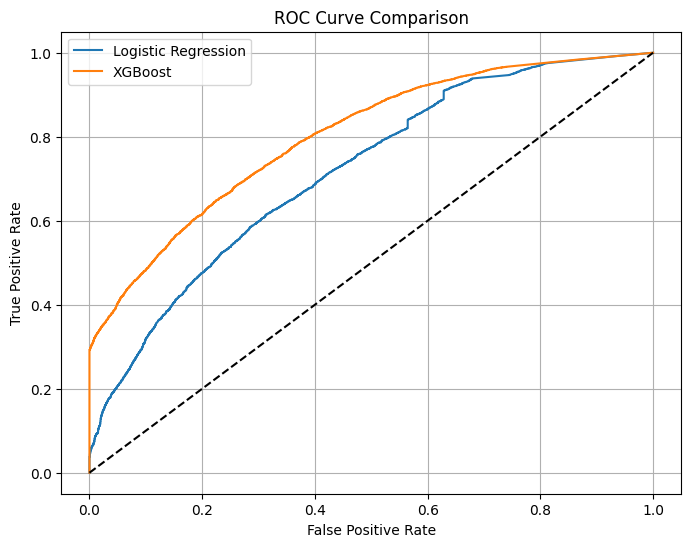

In [20]:
from sklearn.metrics import roc_curve

# Get ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

### Key Components of the ROC Curve:

- **True Positive Rate (TPR)**: Also known as sensitivity or recall, it is the proportion of actual positive cases correctly identified by the model. It's plotted on the y-axis.

- **False Positive Rate (FPR)**: It is the proportion of actual negative cases incorrectly identified as positive by the model. It's plotted on the x-axis.

- The **diagonal dashed line** represents a random classifier, which has no discrimination power. If a model's ROC curve is close to this line, it is performing poorly.

### Insights from the Plot:

- **Logistic Regression** (blue curve) and **XGBoost** (orange curve) both have good performance, as their curves are significantly above the diagonal line.
  
- **XGBoost** performs slightly better than Logistic Regression, as its curve is closer to the top-left corner (where TPR is high and FPR is low). This means XGBoost is better at distinguishing between positive and negative classes.

- Both models show similar behavior at the beginning (with low FPR), but XGBoost outperforms as it achieves higher TPRs with lower FPR compared to Logistic Regression.

- The curve's distance from the diagonal line gives a sense of model performance: the further away, the better the model.

# Business Recommendations for Starbucks Offer Strategy

---

## 1. Targeting Strategy

### Who Should Get BOGO vs. Discount Offers?

- **BOGO Offers Work Best For:**
  - Younger customers (**ages 25–34**) with **medium to high income** ($70k–$100k).
  - **Male customers** tend to complete BOGO offers more often after viewing.
  - Customers with high transaction frequency (frequent app users).
  - Offers are **most effective when viewed** — strong uplift.

- **Discount Offers Work Best For:**
  - Older customers (**ages 50–65+**), especially **females**.
  - **Lower-income groups (<$70k)** — more price sensitive.
  - More likely to complete offers **even without viewing**.
  - Effective for less tech-engaged users.

---

## 2. Who Responds Without Viewing the Offer?

- **High-income customers ($100k+)** often complete offers **without viewing them**.
  - These users are likely making regular purchases regardless of the promotion.
  - Suggests **offers don’t influence behavior** — avoid incentivizing unnecessarily.

- **Long-term loyal users** (members for >2 years) show similar patterns.
  - Consider targeting only when churn risk is detected.

---

## 3. Cost-Efficiency Recommendations

- **Avoid targeting** users who:
  - Regularly complete offers but **don’t view them**.
  - Have **high baseline spending**.

- **Target** users who:
  - Are **infrequent or price-sensitive buyers**.
  - Show **increased purchase behavior** only after viewing offers.

---

## 4. Channel Preferences

- **Email**:
  - Most effective for **older customers (50+)**.
  - Higher view and completion rates through email for discount offers.

- **Mobile App**:
  - Highly effective for **25–45 age range**.
  - Especially good for **BOGO** promotions with push notifications.

- **Web**:
  - Generally lower engagement.
  - Use only when paired with other channels.